## 1. Import libraries

In [1]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [2]:
import cv2 
import mediapipe as mp
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
EPOCHS = 300
RANDOM_SEED = np.random.seed(10)
BATCH_SIZE = 32

## 2. Initialize MediaPipe modules

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model 
mp_drawing = mp.solutions.drawing_utils # Drawing utilities 
mp_face_mesh = mp.solutions.face_mesh

In [5]:
#     conda create -n my_gpu_env python=3.x
#     conda activate my_gpu_env

# conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
import torch
torch.cuda.is_available()

True

## 3. Define Helper

In [6]:
def mediapipe_detection(image, model): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.setflags(write=False)         # Image is no longer writable
    results = model.process(image)      # Make prediction
    image.setflags(write=True)          # Image is now writable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


## 4. Drawing Function

In [7]:
def draw_styled_landmarks(image, results):

    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),  
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

## 5. Main Video Capturing Logic 
(show-no need for training)

In [8]:
# #Main function 
# cap = cv2.VideoCapture(0) 
# # Set mediapipe model  
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: 
#     while cap.isOpened(): 
  
#         # Read feed 
#         ret, frame = cap.read() 
  
#         # Make detections 
#         image, results = mediapipe_detection(frame, holistic) 
#         print(results) 
          
#         # Draw landmarks 
#         draw_styled_landmarks(image, results) 
  
#         # Show to screen 
#         cv2.imshow('Holistic Model Output', image) 
  
#         # Break gracefully 
#         if cv2.waitKey(10) & 0xFF == ord('q'): 
#             break
#     cap.release() 
#     cv2.destroyAllWindows()

## 6. Extract Keypoint Values 
(x,y,z values from detected body + store in numpy arr or "0")

In [9]:
#same logic as above but in function, so can be used
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) # flatten arr of points x,y,z visibility values - single vector

In [10]:
# test f(x) if correct num
# extract_keypoints(results).shape

In [11]:
# test f(x) if correct num
# len(results.face/pose/lh/rh_landmarks.landmark) = 
# face model has 468*3 + pose(33*4) + lh/rh(21*3 and 21*3)
468*3+33*4+21*3+21*3 #total keypoints

1662

## 7. Setup Folders for Collection

In [12]:
#var that holds path for exported data (numpy arrays)
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['idontknow', 'areyouok', 'idontunderstand'])

# 30 videos worth of data (sequence of data)
no_sequences = 50 # 50 * 1662 keypoints to detect actions

# Videos are going to be 50 frames in length
sequence_length = 50

no need to rerun

In [13]:
# # 1 folder for each action(3) and inside 1 folder for each sequence(0-29)
# for action in actions: 
#     for sequence in range(no_sequences):
#         try: 
#             os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
#         except: # if created -> pass
#             pass

## 8. Collect Keypoint Values for Training and Testing
no need to re-run (have collected)

In [14]:
# cap = cv2.VideoCapture(0)
# # Set mediapipe model 
# with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
#     # NEW LOOP
#     # Loop through actions
#     for action in actions:
#         # Loop through sequences aka videos
#         for sequence in range(no_sequences):
#             # Loop through video length aka sequence length
#             for frame_num in range(sequence_length):

#                 # Read feed
#                 ret, frame = cap.read()

#                 # Make detections
#                 image, results = mediapipe_detection(frame, holistic)
# #                 print(results)

#                 # Draw landmarks
#                 draw_styled_landmarks(image, results)
                
#                 # NEW Apply wait logic
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
#                     cv2.waitKey(2000)
#                 else: 
#                     cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     # Show to screen
#                     cv2.imshow('OpenCV Feed', image)
                
#                 # NEW Export keypoints
#                 keypoints = extract_keypoints(results)
#                 npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints) #to save 'npy_path.npy' array of resulting keypoints

#                 # Break gracefully
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    
#     cap.release()
#     cv2.destroyAllWindows()

In [15]:
# cap.release()
# cv2.destroyAllWindows()

## 9. Preprocess Data and Create Labels and Features

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # to one-hot encoding data

In [17]:
label_map = {label:num for num, label in enumerate(actions)}
# label dictionary to represent each one of our action

In [18]:
label_map

{np.str_('idontknow'): 0,
 np.str_('areyouok'): 1,
 np.str_('idontunderstand'): 2}

In [19]:
# sequences, labels = [], [] #x, y data
# for action in actions:
#     for sequence in range(no_sequences):
#         window = []
#         for frame_num in range(sequence_length):
#             res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
#             window.append(res) #grab frame, add to window(video)
#         sequences.append(window)
#         labels.append(label_map[action])

## With augmentation

In [20]:
# applying augmentation to each frame
def augment_landmarks(frame, apply_prob=0.5): # probability of applying <50%
    augmented = frame.copy()

    if np.random.rand() < apply_prob:
        # Gaussian
        augmented = augmented + np.random.normal(0, 0.01, augmented.shape)

    if np.random.rand() < apply_prob:
        # Scale
        scale = np.random.uniform(0.9, 1.1)
        augmented = augmented * scale

    if np.random.rand() < apply_prob:
        # Translation (shifting)
        shift = np.random.uniform(-0.05, 0.05, augmented.shape)
        augmented = augmented + shift

    if np.random.rand() < apply_prob:
        if augmented.ndim == 2 and augmented.shape[1] >= 2:
            theta = np.random.uniform(-10, 10) * np.pi / 180
            rotation_matrix = np.array([
                [np.cos(theta), -np.sin(theta)],
                [np.sin(theta), np.cos(theta)]
            ])
            augmented[:, :2] = augmented[:, :2] @ rotation_matrix
    
    return augmented

In [21]:
# apply augmentation on sequence of frames (50)
def augment_sequence(windows, apply_prob=0.3, target_len=50):
    augmented = np.array(windows).copy()
    if np.random.rand() < apply_prob and len(augmented) > 1:
        # drop random frame
        drop_idx = np.random.randint(0, len(augmented))
        augmented = np.delete(augmented, drop_idx, axis=0)

    if np.random.rand() < apply_prob:
        shift = np.random.randint(-2,2)
        augmented = np.roll(augmented, shift=shift, axis=0)
    
    if np.random.rand() < apply_prob:
        # Speed up/Slow down
        factor = np.random.choice([0.9, 1.1])
        idxs = np.linspace(0, len(augmented) - 1, int(len(augmented) * factor))
        idxs = np.clip(np.round(idxs), 0, len(augmented) - 1).astype(int)
        augmented = augmented[idxs]

    if len(augmented) < target_len:
        pad_width = ((0, target_len - len(augmented)), (0, 0))
        augmented = np.pad(augmented, pad_width, mode='constant')
    elif len(augmented) > target_len:
        augmented = augmented[:target_len]

    return augmented


In [22]:
sequences, labels = [], [] #x, y data
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res) #grab frame, add to window(video)

        # Keep original but also add augmented copy
        sequences.append(window)
        labels.append(label_map[action])

        aug_window = []
        for frame in window:
            aug_window.append(augment_landmarks(frame))
        aug_window = augment_sequence(aug_window)

        sequences.append(aug_window)
        labels.append(label_map[action])

In [23]:
X = np.array(sequences)

In [24]:
X.shape

(300, 50, 1662)

In [25]:
y = to_categorical(labels).astype(int) #to 1 hot encoding

In [26]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1,

In [27]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [28]:
# X_train.shape

In [29]:
# y_test.shape

## 10. Build and Train LSTM Neural Network

In [30]:
from tensorflow.keras.models import Sequential #sequential api
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard #to monitor model as its training
from sklearn.model_selection import KFold, GroupKFold
from tensorflow.keras.regularizers import l2

In [31]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [32]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
# Group each sequence by its sequence number - so all frames from 1 sequence are in same group
groups = np.repeat(np.arange(len(sequences)), 1)
kfold = GroupKFold(n_splits=5)

## Simplify Model

In [33]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
es_callback = EarlyStopping(monitor='val_categorical_accuracy', patience=100, restore_best_weights=True, verbose=1)
rp_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=1e-5, verbose=1)

In [34]:
fold_accuracies = []
fold_losses = []
for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y, groups)):
    print(f"Fold {fold+1}")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = Sequential()
    # model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(50,1662)))
    model.add(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer = l2(1e-5), input_shape=(50,1662))) # L2
    model.add(BatchNormalization())
    # model.add(Dropout(0.2)) # 20% neurons off
    # model.add(LSTM(32, return_sequences=False, activation='relu'))
    model.add(LSTM(32, return_sequences=False, kernel_regularizer = l2(1e-5), activation='relu')) # L2
    model.add(Dropout(0.2))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-5))) # L2 1e-4 before (1e-5)
    model.add(Dense(actions.shape[0], activation='softmax'))

    OPTIMIZER = Adam(learning_rate=1e-4) # 1e-4 before (2e-4)
    
    model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[es_callback, rp_callback,tb_callback], batch_size=BATCH_SIZE)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[rp_callback,tb_callback], batch_size=BATCH_SIZE)
    loss, acc = model.evaluate(X_val, y_val, verbose=0)
    fold_losses.append(loss)
    fold_accuracies.append(acc)

print(f"Mean accuracy over folds: {np.mean(fold_accuracies)}")
print(f"Mean loss over folds: {np.mean(fold_losses)}")
print("Loss per fold: ", [f"{loss:.4f}" for loss in fold_losses])
print("Accuracy per fold: ", [f"{acc:.4f}" for acc in fold_accuracies])
print(f"Std Accuracy: {np.std(fold_accuracies):.4f}")

Fold 1


c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\User\anaconda3\envs\cuda\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - categorical_accuracy: 0.3583 - loss: 1.1088 - val_categorical_accuracy: 0.3167 - val_loss: 1.1625 - learning_rate: 1.0000e-04
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - categorical_accuracy: 0.4292 - loss: 0.9908 - val_categorical_accuracy: 0.3167 - val_loss: 1.2509 - learning_rate: 1.0000e-04
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.4500 - loss: 0.9287 - val_categorical_accuracy: 0.3167 - val_loss: 1.2968 - learning_rate: 1.0000e-04
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - categorical_accuracy: 0.6208 - loss: 0.8018 - val_categorical_accuracy: 0.3167 - val_loss: 1.5227 - learning_rate: 1.0000e-04
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - categorical_accuracy: 0.5542 - loss: 0.8090 - val_categorical_accuracy: 0.3167 - val_loss: 1.3433 - learning_rate: 1.0000e-04
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 259ms/step - categorical_accuracy: 0.5708 - loss: 0.8828 - val_ca

In [35]:
# model = Sequential()
# # model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(50,1662)))
# model.add(LSTM(64, return_sequences=True, activation='relu', kernel_regularizer = l2(1e-5), input_shape=(50,1662))) # L2
# model.add(BatchNormalization())
# # model.add(Dropout(0.2)) # 20% neurons off
# # model.add(LSTM(32, return_sequences=False, activation='relu'))
# model.add(LSTM(32, return_sequences=False, kernel_regularizer = l2(1e-5), activation='relu')) # L2
# model.add(Dropout(0.2))
# # model.add(Dense(32, activation='relu'))
# model.add(Dense(32, activation='relu', kernel_regularizer=l2(1e-5))) # L2 1e-4 before (1e-5)
# model.add(Dense(actions.shape[0], activation='softmax'))

categorical_crossentropy -> multi-class classification

binary_crossentropy -> binary-class classification

MSE -> regressions

In Terminal move to Logs/train: 

tensorboard --logdir=. (to see logs)

In [36]:
# tensorboard --logdir=. 
# to see logdir

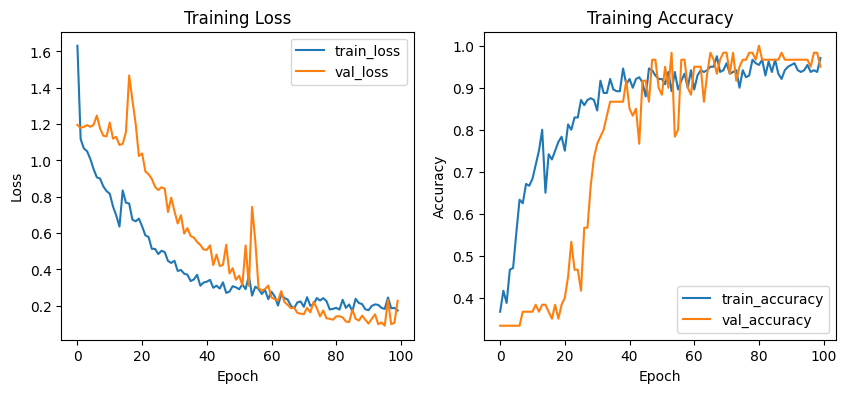

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='train_accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='val_accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [38]:
model.summary()
# LSTM not CNN layers, cuz CNN needs more data

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 50, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,367,563 (5.22 MB)

 Trainable params: 455,811 (1.74 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 911,624 (3.48 MB)

##  Plot Augmentations

In [39]:
def plot_landmarks(original, augmented, num_points=543):
    if (original.ndim == 1):
        num_points = original.size // 3
        original = original.reshape((num_points, 3))
        augmented = augmented.reshape((num_points, 3))
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.scatter(original[:,0], original[:,1], c='blue', s=10)
    plt.title("Original")
    plt.gca().invert_yaxis()

    plt.subplot(1,2,2)
    plt.scatter(augmented[:,0], augmented[:,1], c='red', s=10)
    plt.title("Augmented")
    plt.gca().invert_yaxis()

    plt.show()

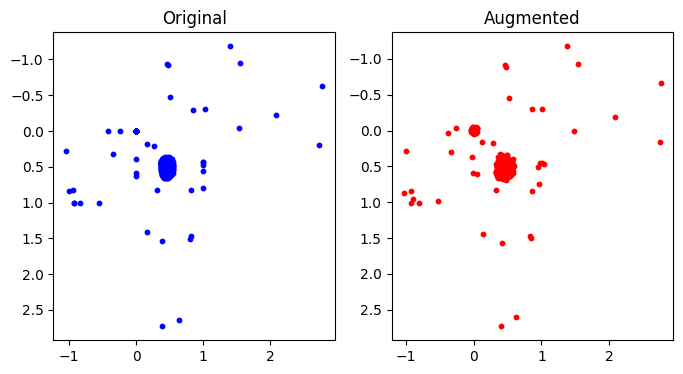

In [40]:
frame = np.load('../Multimodal_action-emotion_detection/MP_Data/areyouok/0/2.npy')
aug_frame = augment_landmarks(frame)
plot_landmarks(frame, aug_frame)

## 11. Make Predictions

In [41]:
res = model.predict(X)
# res = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


In [42]:
actions[np.argmax(res[1])] #train data val

np.str_('idontknow')

In [43]:
actions[np.argmax(y[1])] #pred of model
# actions[np.argmax(y_test[1])] #pred of model

np.str_('idontknow')

## 12. Save Model and Load Weights

In [44]:
model.save('stab_stratk_early.h5')

In [45]:
model.load_weights('stab_stratk_early.h5')

# 13. Evaluation using Confusion Matrix and Accuracy


In [46]:
yhat = model.predict(X)
# yhat = model.predict(X_test)

# axis=1 -> want to convert second dim in the arr
# ytrue = np.argmax(y_test, axis=1).tolist()
ytrue = np.argmax(y, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist() # numbers of classes

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step


In [47]:

from sklearn.metrics import accuracy_score
accuracy_score(ytrue, yhat)

0.3333333333333333

## Check class imbalance （label-lvl）

In [48]:
import pandas as pd

# 1-hot encoded to 3 classes back to check
y_idx = np.argmax(y, axis=1)
# count number of samples(sequences) for each class
val_counts = pd.Series(y_idx).value_counts().sort_index()
print("Counts per class:\n", val_counts)
# Divided to get proportion
print("\nProportions:\n", (val_counts / val_counts.sum()).round(3))


Counts per class:
 0    100
1    100
2    100
Name: count, dtype: int64

Proportions:
 0    0.333
1    0.333
2    0.333
Name: count, dtype: float64


## Check class imbalance （zero frames)

In [49]:
root = "MP_Data"
rows = []

# loop over each sentence (3)
for action in os.listdir(root):
    action_dir = os.path.join(root, action)
    # loop over each sequence (50)
    for seq in os.listdir(action_dir):
        seq_dir = os.path.join(action_dir, seq)
        # count frames in sequence that are all zeros
        frame_files = sorted(os.listdir(seq_dir))
        zeros = 0
        for f in frame_files:
            arr = np.load(os.path.join(seq_dir, f))
            # check if keypoints in frame are 0
            if np.allclose(arr, 0):
                zeros += 1
        rows.append({"action": action, "sequence": int(seq),
                     "n_frames": len(frame_files), "n_zero_frames": zeros,
                     "pct_zero": zeros / max(1, len(frame_files))})
df = pd.DataFrame(rows)
print(df.groupby("action")["pct_zero"].describe())

                 count  mean  std  min  25%  50%  75%  max
action                                                    
areyouok          50.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
idontknow         50.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0
idontunderstand   50.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


# 14. Test in Real Time

In [ ]:
# f to render probabilities
colors = [(245,117,16), (117,245,16), (16,117,245)] 
# color combo for each action: hello, thanks, iloveyou
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40),
                    (int(prob*100), 90+num*40),
                    colors[num], -1
        ) 
        # bar dynamically changes based on probability (longer = higher)
        cv2.putText(
            output_frame, actions[num],
            (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX,
            1, (255,255,255),
            2, cv2.LINE_AA)
        
    return output_frame

# 15. Real time test

In [ ]:
# 1. New detection variables
sequence = [] # append 50 frames, once got 50 frames, predict
sentence = [] # concatenate history of detection together
predictions = []
threshold = 0.3

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints) 
        # sequence = sequence[:50] # but still taking first 50 frames, although added to the end
        sequence = sequence[-50:]
        
        if len(sequence) == 50:
            res = model.predict(np.expand_dims(sequence, axis=0))[0] #pass 1 sequence at a time
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res)) # append all preds to prediction arr
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): # grab only last 10 preds and only unique
                if res[np.argmax(res)] > threshold: #check if res above threshold 0.5
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]: #check if current action isn't same as last sentence
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1) # top corner, size, color, filled rect
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA) 
        # render sentence with space between (3,30 starting position)(font, font size, font color, font line width, line type)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# model.predict(X_test[0]) # shape is incorrect ERROR!!!!
X_test[0].shape # model expects (num_sequences, 50 1662) -> expand dims

In [ ]:
np.expand_dims(X_test[0], axis=0).shape

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

In [ ]:
res[np.argmax(res)] > threshold

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))